# Automatic Brightness
#### Machine Learning model to predict the brightness of the lamp, based on the current ambient light (in lux) and the user's desired lux. Link to the dataset: https://www.kaggle.com/datasets/ziya07/iot-based-environmental-dataset


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Libraries imported successfully.")

Libraries imported successfully.


## Desk Lamp Characteristics
The physical characteristics of the desk lamp that this IoT
system will control are based on the reference model Xiaomi Mi LED Desk Lamp 1S and are crucial for
generating a realistic dataset.

In [ ]:
# Define the constants for the reference lamp
LAMP_MAX_LUX = 1000.0  # Maximum illuminance the lamp can add (in Lux)
LAMP_MIN_LUX = 0.0     # Minimum illuminance (when off)

print(f"Lamp model defined: capable of providing {LAMP_MIN_LUX} to {LAMP_MAX_LUX} Lux.")

Lamp model defined: capable of providing 0.0 to 1000.0 Lux.



## Loading and Preparing Ambient Data

The dataset "university_mental_health_iot_dataset.csv" is used to obtain realistic values of ambient brightness througout the day.
Since the model will rely on the current lux, only the 'lighting_lux' column will be taken from the source.

In [7]:
try:
    df_ambient = pd.read_csv('university_mental_health_iot_dataset.csv')
    ambient_lux_data = df_ambient['lighting_lux'].dropna()
    print(f"Loaded {len(ambient_lux_data)} samples of ambient light.")
    print("\nDescriptive statistics for ambient light (Lux):")
    print(ambient_lux_data.describe())
except FileNotFoundError:
    print("ERROR: File 'university_mental_health_iot_dataset.csv' not found.")
    print("Please upload the file and run the cell again.")
    ambient_lux_data = pd.Series([]) # Create an empty series to avoid later errors

Loaded 1000 samples of ambient light.

Descriptive statistics for ambient light (Lux):
count    1000.000000
mean      301.500435
std        48.873955
min       155.222115
25%       267.386280
50%       300.471291
75%       334.167401
max       502.627506
Name: lighting_lux, dtype: float64


 
## Synthetic Data Generation

 This is the key section. The training dataset is created following this requirements:
 1. 'Ambient Lux': Taken from the real-world data.
 2. 'Desired Lux': A random value between 80% of the maximum ambient light and 100% of the maximum
    ambient light peak additioned to the maximum lux the lamp can provide, but always greater or equal than the current 'Ambient Lux'.
 3. 'Dimming Level (%)': Calculated to cover the difference between Desired and Ambient.

Since the dimming level is computed as a function of the Ambient Lux, the Desired Lux and the Maximum Lux Output of the desk lamp (that is known beforehand), basically the machine learning model is trained to find a relation that is easily, exactly and mathematically obtainable, making this machine learning model swappable for a faster alternative in this IoT application. However, the ml implementation is left as a proof of concept for a future better model.
 

In [ ]:
if not ambient_lux_data.empty:
    # 1. Determine the range for 'Desired Lux'
    global_max_ambient_lux = ambient_lux_data.max()
    desired_lux_min = 0.8 * global_max_ambient_lux
    desired_lux_max = global_max_ambient_lux + LAMP_MAX_LUX

    print(f"\nRange for 'Desired Lux' calculated: from {desired_lux_min:.2f} to {desired_lux_max:.2f} Lux.")

    dataset_list = []
    for ambient_lux in ambient_lux_data:

        random_desired_lux = np.random.uniform(desired_lux_min, desired_lux_max)

        desired_lux = max(ambient_lux, random_desired_lux)

        lux_to_provide = desired_lux - ambient_lux

        lux_to_provide = np.clip(lux_to_provide, LAMP_MIN_LUX, LAMP_MAX_LUX)

        if LAMP_MAX_LUX > 0:
            dimming_level = (lux_to_provide / LAMP_MAX_LUX) * 100
        else:
            dimming_level = 0

        dataset_list.append({
            'Ambient Lux': ambient_lux,
            'Desired Lux': desired_lux,
            'Dimming Level (%)': dimming_level
        })

    df_train = pd.DataFrame(dataset_list)

    print("\nSynthetic dataset generated successfully!")
    print("First 5 rows of the training dataset:")
    print(df_train.head())
    print("\nStatistics of the training dataset:")
    print(df_train.describe())


Range for 'Desired Lux' calculated: from 402.10 to 1502.63 Lux.

Synthetic dataset generated successfully!
First 5 rows of the training dataset:
   Ambient Lux  Desired Lux  Dimming Level (%)
0   323.015836  1387.472711         100.000000
1   412.211259  1242.985504          83.077425
2   386.972786   883.170221          49.619744
3   339.056874   443.924966          10.486809
4   341.460697  1259.889452          91.842875

Statistics of the training dataset:
       Ambient Lux  Desired Lux  Dimming Level (%)
count  1000.000000  1000.000000        1000.000000
mean    301.500435   953.729082          63.209583
std      48.873955   321.609970          29.779184
min     155.222115   405.024738           1.832656
25%     267.386280   660.110298          36.297364
50%     300.471291   971.441488          66.161334
75%     334.167401  1226.046862          92.967156
max     502.627506  1499.801160         100.000000


 
## Machine Learning Model Training
 

 For this IoT application a small and lightweight model is needed.
 A Decision Tree Regressor is an excellent choice because it is interpretable,
 does not require data normalization, and can be easily converted to C code
 with 'emlearn'.
 

In [ ]:
if not ambient_lux_data.empty:

    X = df_train[['Ambient Lux', 'Desired Lux']]
    y = df_train['Dimming Level (%)']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"\nDataset split: {len(X_train)} samples for training, {len(X_test)} for testing.")

    model = DecisionTreeRegressor(max_depth=7, random_state=42)
    model.fit(X_train, y_train)

    print("\nDecisionTreeRegressor model trained successfully.")


Dataset split: 800 samples for training, 200 for testing.

DecisionTreeRegressor model trained successfully.


 
## Model Evaluation
 
To see if the model performs well, an evaluation on the remaining 20% of the dataset is done, using the Mean Squared error, the R-squared and a visual representation to interpret the predictions. The aim is a value of R² close to 1.0, which indicates that nearly all variance is explained by the model.
 


--- Model Performance ---
Mean Squared Error (MSE): 3.8829
R-squared (R²): 0.9952
-------------------------


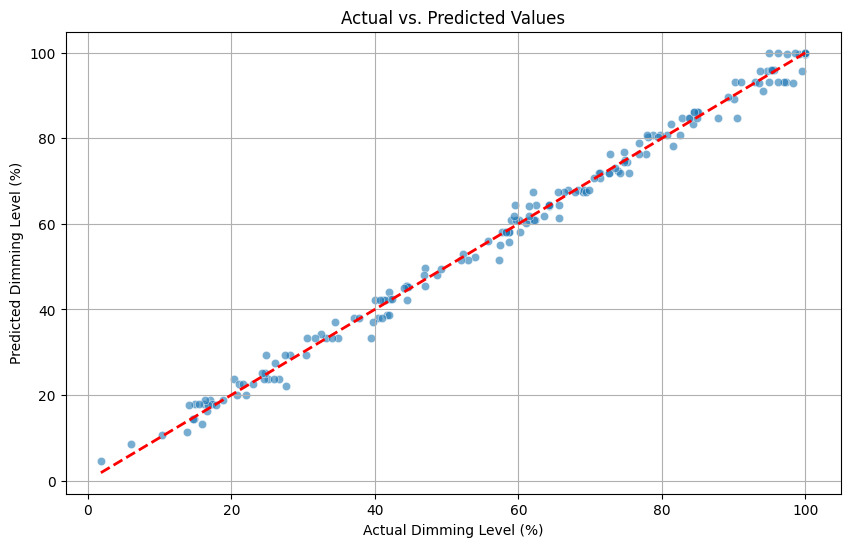

In [ ]:
if not ambient_lux_data.empty:
    
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Performance ---")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-------------------------"

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Dimming Level (%)')
    plt.ylabel('Predicted Dimming Level (%)')
    plt.grid(True)
    plt.show()


## Model Conversion

The model is now ready to be converted to suit the embedded environment of the NORDIC nRF52840 dongle 


In [11]:
import emlearn

if ambient_lux_data.empty:
    print("\nExecution finished with errors because the input file was missing.")
else:
    print("\nTraining workflow complete. The model is ready for conversion to an embedded format.")

    path = 'dimming_forecast.h'

    cmodel = emlearn.convert(model, method='inline')

    cmodel.save(file=path, name='dimming_forecast')

    print('Wrote model to', path)


Training workflow complete. The model is ready for conversion to an embedded format.
Wrote model to dimming_forecast.h
